# Permit Log
The permit log contains multiple attributes with the pattern _xyz\_0_ ... _xyz\_14_.
These might relate to several rounds of submission and rejection or just several approved applications for one permit.
This notebook will investigate this.


In [1]:
from collections import Counter
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')

from src.io import PER, read_log

log = read_log(PER)

In [5]:
# CONFIGURE HERE THE ATTRIBUTE YOU ARE INTERESTED IN (without underscore)
# Activity | Cost Type | DeclarationNumber | OrganizationalEntity | Project | RequestedAmount | RfpNumber | Rfp_id | Task | dec_id
attribute_stem = "(case)_DeclarationNumber" + "_"


In [6]:
def count_actions_in_trace(trace):
    eventtype_counter = Counter({"payments": 0, "rfp_sub": 0, "rfp_app": 0, "rfp_rej":0, "decl_sub": 0, "decl_app": 0, "decl_rej": 0})

    for event in trace:
        if event["concept:name"] == "Payment Handled":
            eventtype_counter["payments"] += 1
        
        elif event["concept:name"].startswith("Request For Payment SUBMITTED"):
            eventtype_counter["rfp_sub"] += 1
        elif event["concept:name"].startswith("Request For Payment FINAL_APPROVED"):
            eventtype_counter["rfp_app"] += 1
        elif event["concept:name"].startswith("Request For Payment REJECTED"):
            eventtype_counter["rfp_rej"] += 1
        
        elif event["concept:name"].startswith("Declaration SUBMITTED"):
            eventtype_counter["decl_sub"] += 1
        elif event["concept:name"].startswith("Declaration FINAL_APPROVED"):
            eventtype_counter["decl_app"] += 1
        elif event["concept:name"].startswith("Declaration REJECTED"):
            eventtype_counter["decl_rej"] += 1
    
    return eventtype_counter

Counter({1: 5308, 0: 978, 2: 116, 3: 12, 4: 4, 5: 3, 10: 1, 14: 1, 7: 1, 6: 1, 9: 1})
Counter({'match': 6419, 'noMatch': 7})


<BarContainer object of 11 artists>

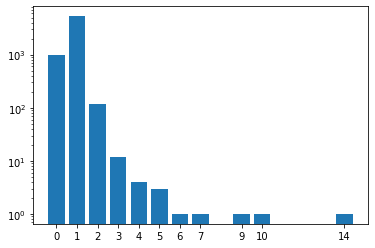

In [10]:
occurence_counter = Counter()
match_counter = Counter({"match": 0, "noMatch": 0})

for trace in log:
    # Look how many attributes are present in this trace concerning the given attribute
    # E.g. number of attributes starting with "DeclarationNumber_" that are not empty or UNKNOWN
    # (After preprocessing, the trace itself has less attributes, therefore, we look into any event)
    trace_attributes = trace[0]
    attribute_count = sum(1 for attr,val in trace_attributes.items() if (attr.startswith(attribute_stem) and val != '' and val != 'UNKNOWN'))
    occurence_counter[attribute_count] += 1

    eventtype_counter = count_actions_in_trace(trace)

    # Case should either have submissions, that are all rejected,
    # otherwise the number of attributes should correspond to the payments made minus payments made for requests for payment
    if ( (eventtype_counter["decl_sub"] - eventtype_counter["decl_ref"] == 0) or
         (attribute_count == (eventtype_counter["payments"] - eventtype_counter["rfp_app"]))):
        match_counter["match"] += 1
    else:
        #print(trace.attributes["id"])
        match_counter["noMatch"] += 1


print(occurence_counter)
print(match_counter)
# Plot number of "filled" attributes. 0 means, no attribute at all, 1 means, there is one attribute with a value and so on
plt.bar(occurence_counter.keys(), occurence_counter.values(), log=True, tick_label=list(occurence_counter.keys()))